In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Load the data
DATA_DIR = '/beegfs/DATA/pritchard/srasp/fluxbypass_aqua/'
n_days = 1
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_sp_fbp_f2.cam2.h1.0000-01-0[1-{n_days}]*',
    decode_times=False)

In [16]:
print(list(ds.data_vars.keys()))

['P0', 'time_bnds', 'date_written', 'time_written', 'ntrm', 'ntrn', 'ntrk', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'mdt', 'nlon', 'wnummax', 'hyai', 'hybi', 'hyam', 'hybm', 'gw', 'ndcur', 'nscur', 'date', 'datesec', 'nsteph', 'DTV', 'FLNS', 'FLNT', 'FLUT', 'FSNS', 'FSNT', 'LHFLX', 'PHQ', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PRECSTEN', 'PRECT', 'PRECTEND', 'PS', 'QAP', 'QRL', 'QRS', 'SHFLX', 'SOLIN', 'SPDQ', 'SPDT', 'T', 'TAP', 'TPHYSTND', 'TS', 'UAP', 'VAP', 'VD01']


In [19]:
ds['TPHYSTND_NORAD'] = ds.TPHYSTND - ds.QRL - ds.QRS

## MSE conservation

In [4]:
# Precipitation term
dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [5]:
# Surface terms
dsurf = ds.LHFLX + ds.SHFLX

In [20]:
# Convection terms
dconv = vint(ds, 'TPHYSTND_NORAD', 1)*C_P + vint(ds, 'PHQ', 1)*L_S #+vint(ds.PHQC)*L_I

In [28]:
dsp = vint(ds, 'SPDT', 1)*C_P + vint(ds, 'SPDQ', 1)*L_S

In [38]:
# Get statistics for a single grid point
ilat, ilon, itime = 0, 0, -1
[d.isel(time=itime, lat=ilat, lon=ilon).values for d in [dprec, dsurf, dconv, dsp]]

[array(-0.07156746, dtype=float32),
 array(16.838099, dtype=float32),
 array(19.21878972),
 array(0.94432083)]

In [37]:
dE = dsurf + dconv + dprec; dE.isel(time=itime, lat=ilat, lon=ilon).values

array(-37.69669805)

In [15]:
ds.SHFLX.isel(time=itime, lat=ilat, lon=ilon).values

array(21.430807, dtype=float32)

In [27]:
ds.LHFLX.isel(time=itime, lat=ilat, lon=ilon).values

array(121.31707, dtype=float32)

In [30]:
(vint(ds, 'TPHYSTND_NORAD', 1).isel(time=itime, lat=ilat, lon=ilon).values*C_P,
 vint(ds, 'SPDT', 1).isel(time=itime, lat=ilat, lon=ilon).values*C_P)

(1210.2160000665372, 1185.6700879383177)

In [32]:
(vint(ds, 'PHQ', 1).isel(time=itime, lat=ilat, lon=ilon).values*L_V,
 vint(ds, 'SPDQ', 1).isel(time=itime, lat=ilat, lon=ilon).values*L_V)

(-1074.8646605068827, -1196.085754289555)

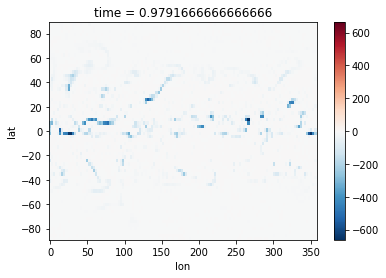

In [13]:
dprec.isel(time=-1).plot()

## I am confused, why not try radiation...

In [39]:
flx_net = ds.FSNT - ds.FSNS - ds.FLNT + ds.FLNS

In [48]:
ds.FSNT

<xarray.DataArray 'FSNT' (time: 48, lat: 64, lon: 128)>
dask.array<shape=(48, 64, 128), dtype=float32, chunksize=(48, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon      (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * time     (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042 0.125 ...
Attributes:
    units:        W/m2
    long_name:    Net solar flux at top of model
    cell_method:  time: mean

In [40]:
drad = vint(ds, 'QRL', C_P) + vint(ds, 'QRS', C_P)

In [41]:
ilat, ilon, itime = 32, 0, -1

In [42]:
flx_net.isel(time=itime, lat=ilat, lon=ilon).values

array(-97.08189, dtype=float32)

In [43]:
drad.isel(time=itime, lat=ilat, lon=ilon).values

array(-96.59567565)

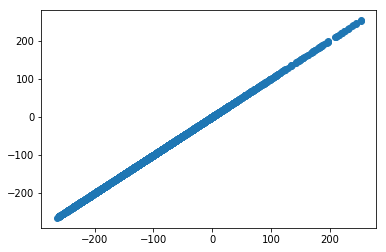

In [44]:
plt.scatter(drad.isel(lon=0), flx_net.isel(lon=0))

In [46]:
# Predict QRL(z), QRS(z), 4*F
# Input PS + SOLIN, TBP, QBP

In [50]:
??get_P_from_ds

In [52]:
ds.hybi

<xarray.DataArray 'hybi' (ilev: 31)>
dask.array<shape=(31,), dtype=float64, chunksize=(31,)>
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 80.7 ...
Attributes:
    long_name:  hybrid B coefficient at layer interfaces

In [58]:
np.expand_dims(ds.PS, 1).shape

(48, 1, 64, 128)

In [56]:
ds.TAP.values.shape

(48, 30, 64, 128)

In [115]:
feature_arrs = np.concatenate(
    [np.expand_dims(ds.PS, 1), np.expand_dims(ds.SOLIN, 1), ds.TAP, ds.QAP], 1)

In [116]:
feature_arrs.shape

(48, 62, 64, 128)

In [117]:
feature_arrs = np.rollaxis(feature_arrs, 1, 4); feature_arrs.shape

(48, 64, 128, 62)

In [118]:
features = feature_arrs.reshape(-1, 62)

In [119]:
target_arrs = np.concatenate(
    [np.expand_dims(ds.FSNT, 1), np.expand_dims(ds.FSNS, 1), 
     np.expand_dims(ds.FLNT, 1), np.expand_dims(ds.FLNS, 1),
     ds.QRL*C_P, ds.QRS*C_P], 1)

In [120]:
target_arrs = np.rollaxis(target_arrs, 1, 4); target_arrs.shape

(48, 64, 128, 64)

In [121]:
targets = target_arrs.reshape(-1, 64)

In [122]:
targets[:, :4] /= 1e4

In [123]:
ngeo = 46*128

In [124]:
features.shape

(393216, 62)

In [125]:
fmeans = features.mean(0)
fstds = features.std(0)

In [126]:
features = (features - features.mean(0)) / features.std(0)

In [127]:
x_trn, x_val = features[:40*ngeo], features[40*ngeo:]
y_trn, y_val = targets[:40*ngeo], targets[40*ngeo:]

In [128]:
from keras.layers import *

In [129]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
outp = Dense(64)(x)
net = keras.models.Model(inp, outp)

In [130]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 62)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16128     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                16448     
Total params: 98,368
Trainable params: 98,368
Non-trainable params: 0
_________________________________________________________________


In [131]:
net.compile('adam', 'mse')

In [133]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=5, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/5
235520/235520 [==============================] - 3s 13us/step - loss: 2.1787e-04 - val_loss: 1.8812e-04
Epoch 2/5
235520/235520 [==============================] - 3s 13us/step - loss: 2.0530e-04 - val_loss: 1.7666e-04
Epoch 3/5
235520/235520 [==============================] - 3s 13us/step - loss: 1.9523e-04 - val_loss: 1.6909e-04
Epoch 4/5
235520/235520 [==============================] - 3s 13us/step - loss: 1.8731e-04 - val_loss: 1.6338e-04
Epoch 5/5
235520/235520 [==============================] - 3s 13us/step - loss: 1.8024e-04 - val_loss: 1.5806e-04


In [134]:
net.optimizer.lr = 1e-4

In [139]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3776e-04 - val_loss: 1.2548e-04
Epoch 2/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3458e-04 - val_loss: 1.2067e-04
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3395e-04 - val_loss: 1.1985e-04
Epoch 4/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3117e-04 - val_loss: 1.1984e-04
Epoch 5/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2961e-04 - val_loss: 1.1887e-04
Epoch 6/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2687e-04 - val_loss: 1.1591e-04
Epoch 7/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2514e-04 - val_loss: 1.1622e-04
Epoch 8/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2316e-04 - val_loss: 1.1482e-04
Epoch 9/10
235520/235520 [==

In [136]:
preds = net.predict(x_val, batch_size=1024)

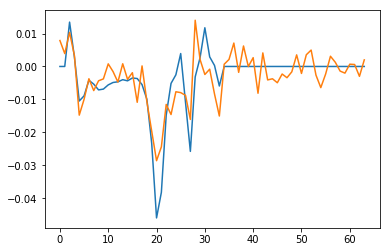

In [138]:
plt.plot(y_val[1000])
plt.plot(preds[1000]);

In [144]:
hyai, hybi, P0 = ds.hyai.values, ds.hybi.values, ds.P0.values

In [146]:
x_val.shape

(157696, 62)

In [155]:
# Get energy conservation from xs and ys!
PS = x_val[:, 0] * fstds[0] + fmeans[0]
P = P0 * hyai + PS[:, None] * hybi
dP = P[:, 1:] - P[:, :-1]

In [157]:
dP.shape

(157696, 30)

In [160]:
vintQRL = np.sum(y_val[:, -60:-30]*dP/G, 1)
vintQRS = np.sum(y_val[:, -30:]*dP/G, 1)

In [166]:
signs = np.array([1, -1, -1, 1])

In [172]:
F1to3 = np.sum(y_val[:, :3]*signs[:3], 1) * 1e4
F1to4 = np.sum(y_val[:, :4]*signs, 1) * 1e4

In [224]:
F4 = (vintQRL + vintQRS - F1to3)

In [173]:
vintQRL + vintQRS

array([ -41.21759988,  -41.02965561,  -53.37605315, ..., -100.63945054,
       -102.24919032,  -79.09752523])

In [174]:
F1to4

array([ -41.42508144,  -41.23616498,  -53.64470184, ..., -101.14599951,
       -102.76385583,  -79.49565537])

In [221]:
F1to3

array([ -61.04013417, -107.53715411, -162.99573705, ..., -185.21094695,
       -177.43123695, -169.82212663])

In [225]:
F4

array([ 19.82253429,  66.50749849, 109.61968389, ...,  84.57149641,
        75.18204663,  90.7246014 ])

In [176]:
vintQRL + vintQRS -F1to3

array([ 19.82253429,  66.50749849, 109.61968389, ...,  84.57149641,
        75.18204663,  90.7246014 ])

In [178]:
y_val[:, 3]*1e4

array([ 19.615053,  66.30099 , 109.351036, ...,  84.06495 ,  74.66738 ,
        90.32647 ], dtype=float32)

In [175]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

In [210]:
class ConservationLayer(Layer):

    def __init__(self, **kwargs):
        super(ConservationLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ConservationLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        """
        features -> 62 layers
        x -> 63 layers
        """
        features, x = arrs
        PS = features[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        vintQRL = K.sum(x[:, -60:-30]*dP/G, 1)
        vintQRS = K.sum(x[:, -30:]*dP/G, 1)
        signs = np.array([1, -1, -1, 1], dtype='float32')
        F1to3 = K.sum(x[:, :3]*signs[:3], 1) * 1e4
        F4 = (vintQRL + vintQRS - F1to3) / 1e4
        return K.concatenate([x, K.reshape(F4, (-1, 1))], 1)

    def compute_output_shape(self, input_shape):
        return (input_shape[1][0], input_shape[1][1]+1)

In [211]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(63)(x)
outp = ConservationLayer()([inp, tmp])
net = keras.models.Model(inp, outp)

In [212]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 256)          16128       input_19[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_36 (LeakyReLU)      (None, 256)          0           dense_52[0][0]                   
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 256)          65792       leaky_re_lu_36[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [213]:
net.compile('adam', 'mse')

In [214]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=5, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/5
235520/235520 [==============================] - 4s 19us/step - loss: 0.0047 - val_loss: 6.1804e-04
Epoch 2/5
235520/235520 [==============================] - 4s 15us/step - loss: 4.8064e-04 - val_loss: 3.6480e-04
Epoch 3/5
235520/235520 [==============================] - 4s 15us/step - loss: 3.3807e-04 - val_loss: 2.8086e-04
Epoch 4/5
235520/235520 [==============================] - 4s 15us/step - loss: 2.8045e-04 - val_loss: 2.3862e-04
Epoch 5/5
235520/235520 [==============================] - 4s 15us/step - loss: 2.4891e-04 - val_loss: 2.1317e-04


In [215]:
preds = net.predict(x_val, batch_size=1024)

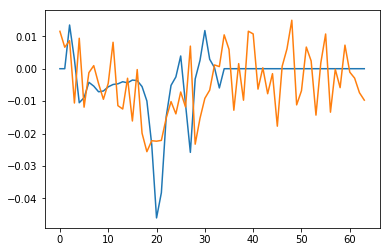

In [226]:
plt.plot(y_val[1000])
plt.plot(preds[1000]);

In [249]:
def get_dE(x, y):
    PS = x[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(y[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(y[:, -30:]*dP/G, 1)
    signs = np.array([1, -1, -1, 1])
    #F1to3 = np.sum(y[:, :3]*signs[:3], 1) * 1e4
    F1to4 = np.sum(y[:, :4]*signs, 1) * 1e4
    #F4 = (vintQRL + vintQRS - F1to3) / 1e4
    #out_y = np.concatenate([y, np.reshape(F4, (-1, 1))], 1)
    return vintQRL + vintQRS, F1to4

In [250]:
get_dE(x_val, y_val)

(array([ -41.21759988,  -41.02965561,  -53.37605315, ..., -100.63945054,
        -102.24919032,  -79.09752523]),
 array([ -41.42508144,  -41.23616498,  -53.64470184, ..., -101.14599951,
        -102.76385583,  -79.49565537]))

In [251]:
get_dE(x_val, preds)

(array([ -76.79050152,  -87.4909372 ,  -73.91774505, ..., -107.31936745,
         -78.12341873, -102.87592715]),
 array([-107.52926581, -132.59546016, -312.47414649, ...,   55.07215858,
          43.46565809,   76.63803175]))

In [257]:
def debug(arrs):
        """
        features -> 62 layers
        x -> 63 layers
        """
        features, x = arrs
        PS = features[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        vintQRL = np.sum(x[:, -60:-30]*dP/G, 1)
        vintQRS = np.sum(x[:, -30:]*dP/G, 1)
        signs = np.array([1, -1, -1, 1], dtype='float32')
        F1to3 = np.sum(x[:, :3]*signs[:3], 1) * 1e4
        F4 = (vintQRL + vintQRS - F1to3) / 1e4
        return np.concatenate([x, np.reshape(F4, (-1, 1))], 1)

In [260]:
test = debug([x_val, np.random.rand(x_val.shape[0], 63)])

In [261]:
test.shape

(157696, 64)

In [262]:
get_dE(x_val, test)

(array([10771.76183786,  8428.88843034,  9235.49965444, ...,
        10088.12116751,  8878.14609199,  9629.00356374]),
 array([ 1226.06540204,  7087.97136055, -3331.11885512, ...,
         5745.15096949, -3728.73875679,  5023.44141538]))

In [237]:
get_dE(np.random.rand(2, 62), np.random.rand(2, 63))

(array([9940.75630184, 9788.95491879]), array([-106.82511741, 7409.9099584 ]))

In [216]:
# Get energy conservation from xs and ys!
PS = x_val[:, 0] * fstds[0] + fmeans[0]
P = P0 * hyai + PS[:, None] * hybi
dP = P[:, 1:] - P[:, :-1]

In [217]:
dP.shape

(157696, 30)

In [160]:
vintQRL = np.sum(y_val[:, -60:-30]*dP/G, 1)
vintQRS = np.sum(y_val[:, -30:]*dP/G, 1)

In [166]:
signs = np.array([1, -1, -1, 1])

In [172]:
F1to3 = np.sum(y_val[:, :3]*signs[:3], 1) * 1e4
F1to4 = np.sum(y_val[:, :4]*signs, 1) * 1e4

In [173]:
vintQRL + vintQRS

array([ -41.21759988,  -41.02965561,  -53.37605315, ..., -100.63945054,
       -102.24919032,  -79.09752523])

In [174]:
F1to4

array([ -41.42508144,  -41.23616498,  -53.64470184, ..., -101.14599951,
       -102.76385583,  -79.49565537])

In [176]:
vintQRL + vintQRS -F1to3

array([ 19.82253429,  66.50749849, 109.61968389, ...,  84.57149641,
        75.18204663,  90.7246014 ])

In [178]:
y_val[:, 3]*1e4

array([ 19.615053,  66.30099 , 109.351036, ...,  84.06495 ,  74.66738 ,
        90.32647 ], dtype=float32)